In [1]:
import sys
sys.path.append('D:\\Desktop\\Lipschitz_DSNN') 

In [2]:
import numpy as np
import torch
import os
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
# from torch.utils import tensorboard
import torch.nn as nn

from architectures.base_model import BaseModel
from architectures.simple_fc import SimpleFC
from layers.lipschitzlinear import LipschitzLinear
from projections.fc_projections import identity, bjorck_orthonormalize_fc, layerwise_orthogonal_fc
from utils import metrics, utilities, spline_utils
from dataloader.Function_1D import Function1D, generate_testing_set, slope_1_ae, slope_1_flat, cosines, threshold
from activations.linearspline import LinearSpline


In [3]:
### let's load the SimpleFCClassification model
from classification_LS import SimpleFCClassification # it works

In [4]:
## importing the trainer 
from trainer_class_LS_test import CustomDataset, Trainer_classification

In [5]:
### importing some utility functions
from utils_test_classification import plot_confusion_matrix, plot_losses_trained_model

In [6]:
### Area Classification Problem
import numpy as np

# Given function g (vectorized)
g = lambda x: 0.4 * np.sin(-5*x)

# Define the label function (vectorized)
def S_shape_label_fn(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    return np.logical_and(np.abs(x1 - g(x2)) <= 0.3, np.abs(x2) < 0.8).astype(int)

# class 0 DPs: 5000 and # class 1 DPs: 5000


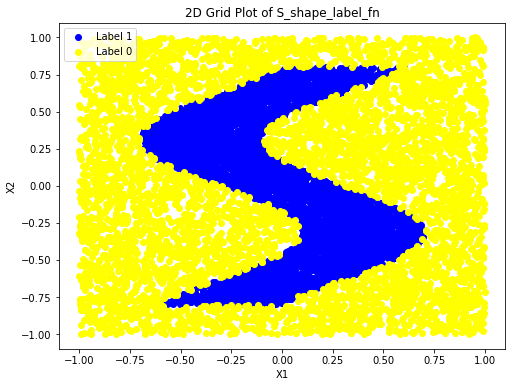

In [7]:
# Function to generate a balanced dataset
def generate_balanced_data(num_dp_per_class):
    x_data = []
    y_data = []
    num_class_0 = 0
    num_class_1 = 0
    
    while num_class_0 < num_dp_per_class or num_class_1 < num_dp_per_class:
        x_candidate = np.random.uniform(-1.0, 1.0, size=(1, 2))
        y_candidate = S_shape_label_fn(x_candidate)
        
        if y_candidate == 0 and num_class_0 < num_dp_per_class:
            x_data.append(x_candidate)
            y_data.append(y_candidate)
            num_class_0 += 1
        elif y_candidate == 1 and num_class_1 < num_dp_per_class:
            x_data.append(x_candidate)
            y_data.append(y_candidate)
            num_class_1 += 1

    x_data = np.vstack(x_data)
    y_data = np.concatenate(y_data)
    return x_data, y_data

# Generate balanced data
num_dp_per_class = 5000  # Number of data points per class
x_mat, y_mat = generate_balanced_data(num_dp_per_class)

# Count the number of data points for each class
num_zeros = np.count_nonzero(y_mat == 0)
num_ones = np.count_nonzero(y_mat == 1)
print(f"# class 0 DPs: {num_zeros} and # class 1 DPs: {num_ones}")

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_mat[y_mat == 1, 0], x_mat[y_mat == 1, 1], color='blue', label='Label 1')
plt.scatter(x_mat[y_mat == 0, 0], x_mat[y_mat == 0, 1], color='yellow', label='Label 0')
plt.title('2D Grid Plot of S_shape_label_fn')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
# plt.grid(True)
plt.show()


In [8]:
### I would need this function later.
scale_factor=10
x_mat_new = scale_factor * x_mat
# Given function g (vectorized)
g2 = lambda x: 0.4*scale_factor * np.sin(-5*x/scale_factor)

# Define the label function (vectorized)
def S_shape_label_fn2(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    return np.logical_and(np.abs(x1 - g2(x2)) <= 0.3*scale_factor, np.abs(x2) < 0.8*scale_factor).astype(int)

In [9]:
### function to evaluate the trained model
def evaluate_model(trained_model_input, y_test_fn, dataset_size=100, noise_level=0.003, 
                    want_confusion_matrix=False,
                    print_preds=False, range_of_value=1):
    # Generate test dataset
    x_test = np.random.uniform(-range_of_value, range_of_value, size=(dataset_size, 2)) + noise_level * np.ones(shape=(dataset_size, 2))
    y_test = y_test_fn(x_test)
    #print(f"y_test is:"); print(y_test)

    # Convert to torch tensors
    x_test, y_test = torch.tensor(x_test), torch.tensor(y_test)

    # Make predictions
    with torch.no_grad():
        preds = trained_model_input(x_test)
        if print_preds:
            print("predictions are:")
            print(preds)

    # Calculate accuracy
    acc_test = (preds.squeeze().round() == y_test).float().mean()
    print(f"Test accuracy: {acc_test.item():.4f}")
    # Plot confusion matrix
    if want_confusion_matrix:
        plot_confusion_matrix(preds.squeeze().round(), y_test, classes=["0", "1"])
    
    return x_test, y_test, preds

In [10]:
### model parameters
network_param = {'bias': True,
    'layer_sizes': [2, 8, 8, 1], ### I have changed model a bit
    'projection': 'no_projection' , ### Let's change it from 'orthonormalize' to 'no_projection'
    'weight_initialization': 'He_uniform'}

additional_network_params= {'activation_type': 'linearspline', ### this is of interest
    'groupsort_groupsize': 5,
    'prelu_init': -1,
    'lipschitz_constrained': True,### this is of interest
    'spline_init': 'relu',### this is of interest
    'spline_range': 0.9,### this is of interest [-1,1]
    'spline_scaling_coeff': True,### this is of interest
    'spline_size': 19,#101,###
    'lmbda': 1e-07}### this is of interest [e-10,e2]

for_optimizer = {'lr_spline_coeffs': 5e-05, # This is learning rate for linear splines
    'lr_spline_scaling_coeffs': 0.0005,
    'lr_weights': 0.002}# original 0.002

training_options = {'batch_size': 64*5,  
    'epochs': 100,
    'nbr_models': 1,
    'num_workers': 1,
    'validation_split':0.2}

### for model without bjorck orthonormalisation
config_train_classification = { 'activation_fn_params':additional_network_params,
                            'exp_name' : "S shaped classification",
                            'net_params' : network_param,
                            'optimizer' : for_optimizer,
                            'training_options' : training_options
}

## for model with bjorck orthonormalisation
### creating a new configuration for training the model with bjork orthonormalisation
import copy
config_train_classification_bjork= copy.deepcopy(config_train_classification)
config_train_classification_bjork['net_params']['projection']='orthonormalize'
### lot orthonormalisation
config_train_classification_LOT = copy.deepcopy(config_train_classification)
config_train_classification_LOT['net_params']['projection'] = 'orthonormalize'
config_train_classification_LOT['net_params']['LOT'] = {'LOT_iter': 10}


### Let's test model with LOT 

Without X_scaled

In [11]:
## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_LOT_1 = SimpleFCClassification(
    network_parameters=config_train_classification_LOT['net_params'],
    **additional_network_params)
ds_simple_fc_LOT_1 = ds_simple_fc_LOT_1.to('cpu')
print("model is:"); print(ds_simple_fc_LOT_1)

Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=8, bias=True)
    (3): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [12]:

test_tensor = torch.tensor([[1,2]])
ds_simple_fc_LOT_1.eval()
ds_simple_fc_LOT_1(test_tensor)

: 

Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=8, bias=True)
    (3): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
in Train set: # class 0 DPs: 4024 and # class 1 DPs: 3976
in val set: # class 0 DPs: 976 and # class 1 DPs: 1024


100%|██████████| 25/25 [00:01<00:00, 22.30it/s]


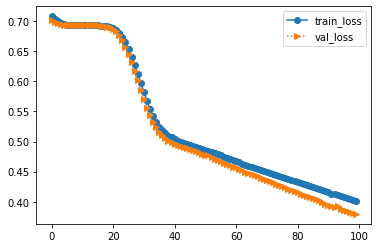

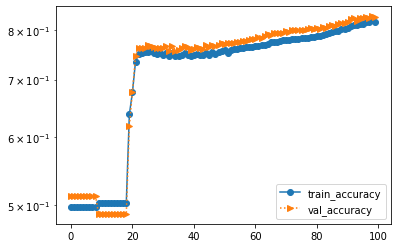

Final training accuracy is: 0.818
Final validation accuracy is: 0.829
--------Trained model's (with LOT orthonormalisation) performance on the test data, X not scaled ------
test number: 1
Test accuracy: 0.8400


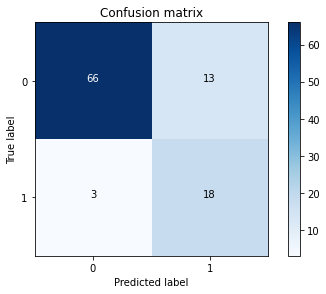

test number: 2
Test accuracy: 0.8400


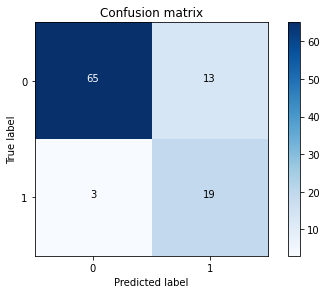

test number: 3
Test accuracy: 0.8800


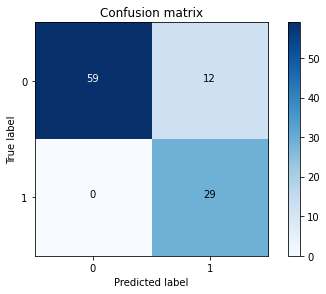

test number: 4
Test accuracy: 0.7500


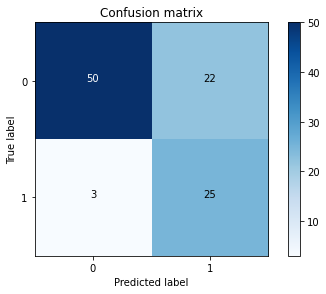

test number: 5
Test accuracy: 0.8300


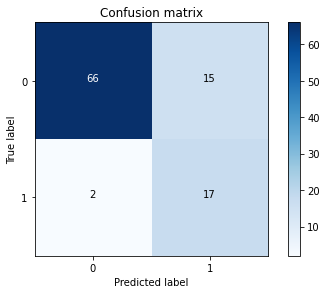

test number: 6
Test accuracy: 0.7100


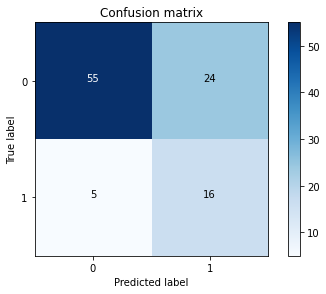

In [11]:
## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_LOT_1 = SimpleFCClassification(
    network_parameters=config_train_classification_LOT['net_params'],
    **additional_network_params)
ds_simple_fc_LOT_1 = ds_simple_fc_LOT_1.to('cpu')
print("model is:"); print(ds_simple_fc_LOT_1)

### instantiate the Trainer 
trainer_classification_LOT_1 = Trainer_classification(
                        model=ds_simple_fc_LOT_1,
                        ###using a roughly balanced dataset
                        xdata=x_mat,
                        ydata=y_mat,
                        ###ROUGHLY BALANCED (because during splitting #class 0 DP could be not exactly = # class 1 DPs)
                        criterion=criterion,
                        config=config_train_classification_bjork,
                        seed=12,
                        device='cpu',
                        print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                        )

### Let's train the model
trainer_classification_LOT_1.train() ### 

### plotting loss curves
plot_losses_trained_model(trainer_classification_LOT_1)

### evaluating the trained model's performance on the test dataset
print("--------Trained model's (with LOT orthonormalisation) performance on the test data, X not scaled ------")
for i in range(0, 6):
    print(f"test number: {i+1}")
    evaluate_model(ds_simple_fc_LOT_1, S_shape_label_fn, 
                    want_confusion_matrix=True, print_preds=False)

With X_scaled = 10* X

  0%|          | 0/25 [00:00<?, ?it/s]

  8%|▊         | 2/25 [00:00<00:01, 19.60it/s]

Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=8, bias=True)
    (3): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
in Train set: # class 0 DPs: 4024 and # class 1 DPs: 3976
in val set: # class 0 DPs: 976 and # class 1 DPs: 1024


100%|██████████| 25/25 [00:01<00:00, 15.69it/s]


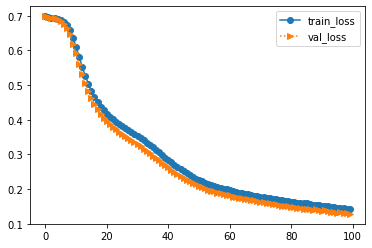

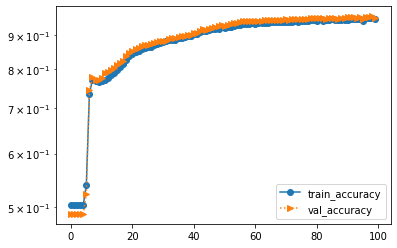

Final training accuracy is: 0.951
Final validation accuracy is: 0.954
--------Trained model's (with LOT orthonormalisation) performance on the test data with X scaled ------
test number: 1
Test accuracy: 0.9100


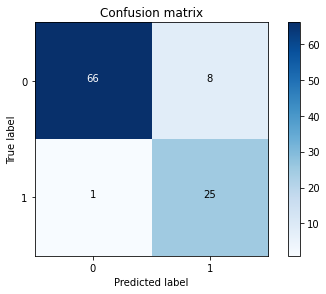

test number: 2
Test accuracy: 0.9500


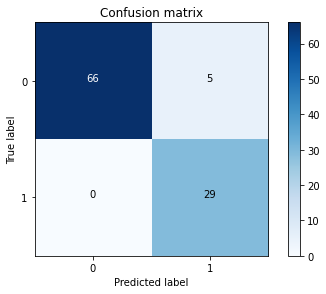

test number: 3
Test accuracy: 0.9300


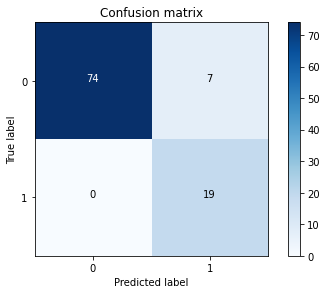

test number: 4
Test accuracy: 0.9900


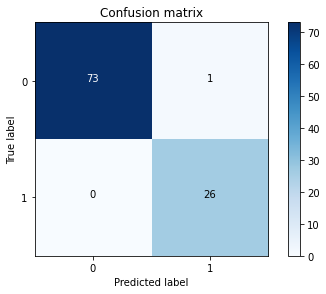

test number: 5
Test accuracy: 0.8900


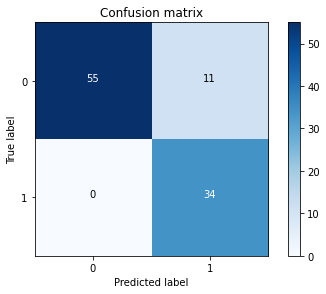

test number: 6
Test accuracy: 0.9300


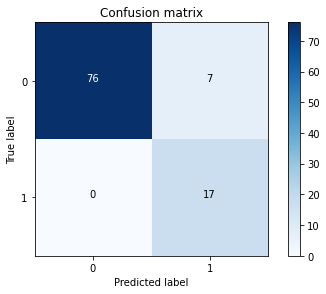

In [12]:
## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_LOT_2 = SimpleFCClassification(
    network_parameters=config_train_classification_LOT['net_params'],
    **additional_network_params)
ds_simple_fc_LOT_2 = ds_simple_fc_LOT_2.to('cpu')
print("model is:"); print(ds_simple_fc_LOT_2)

### instantiate the Trainer 
trainer_classification_LOT_2 = Trainer_classification(
                        model=ds_simple_fc_LOT_2,
                        ###using a roughly balanced dataset
                        xdata=x_mat_new,
                        ydata=y_mat,
                        ###ROUGHLY BALANCED (because during splitting #class 0 DP could be not exactly = # class 1 DPs)
                        criterion=criterion,
                        config=config_train_classification_bjork,
                        seed=12,
                        device='cpu',
                        print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                        )

### Let's train the model
trainer_classification_LOT_2.train() ### 

### plotting loss curves
plot_losses_trained_model(trainer_classification_LOT_2)

### evaluating the trained model's performance on the test dataset
print("--------Trained model's (with LOT orthonormalisation) performance on the test data with X scaled ------")
for i in range(0, 6):
    print(f"test number: {i+1}")
    evaluate_model(ds_simple_fc_LOT_2, S_shape_label_fn2, 
                    want_confusion_matrix=True, print_preds=False,range_of_value=scale_factor)

Observation: 

1. Even with LOT orthogonalisation, it seems that the performance of the model improves on scaling X values.

2. LOT based implementation is almost 2 times faster than Bjoerck based implementation.

### To do:

1. Discuss with prof: SOC and Cayley based orthogonalisation. Also CPL if time permits.
2. Test the code for image based examples (This is quite important). 

### Let's check LOT's performance on digits dataset

In [22]:
from sklearn.datasets import load_digits
from sklearn import model_selection

In [23]:
# setup
digits = load_digits()
images = digits["images"]
flat_images_unnorm= images.reshape((images.shape[0],-1))
print(f"shape of flattened images: {flat_images_unnorm.shape}")
target = digits["target"] 
target_names = digits["target_names"] 

shape of flattened images: (1797, 64)


In [24]:
np.max(flat_images_unnorm), np.min(flat_images_unnorm)# values are not between 0 and 1

(16.0, 0.0)

In [26]:
# normalising the dataset
flat_images = (1./np.max(flat_images_unnorm))*flat_images_unnorm

In [27]:
### even digits as label 0 and odd digits as label 1
tgt = np.where(target%2==0, 0, 1) 
tgt, len(tgt)

(array([0, 1, 0, ..., 0, 1, 0]), 1797)

Without LOT orthonormalisation

In [28]:
import copy

In [29]:
### model parameters
network_param = {'bias': True,
    'layer_sizes': [64, 8, 1], ### we will consider 2-D Example later on
    'projection': 'no_projection' , ### Let's change it from 'orthonormalize' to 'no_projection'
    'weight_initialization': 'He_uniform'}

additional_network_params= {'activation_type': 'linearspline', ### this is of interest
    'groupsort_groupsize': 5,
    'prelu_init': -1,
    'lipschitz_constrained': True,### this is of interest
    'spline_init': 'relu',### this is of interest
    'spline_range': 0.9,### this is of interest [-1,1]
    'spline_scaling_coeff': True,### this is of interest
    'spline_size': 19,#101,###
    'lmbda': 1e-07}### this is of interest [e-10,e2]

for_optimizer = {'lr_spline_coeffs': 5e-05, # idk what exactly is this. Need to look into it well
    'lr_spline_scaling_coeffs': 0.0005,
    'lr_weights': 0.002}# original 0.002, i changed it to 0.01

training_options = {'batch_size': 32,  
    'epochs': 20,
    'nbr_models': 1,
    'num_workers': 1,
    'validation_split':0.1}

config_train_classification_digits = { 'activation_fn_params':additional_network_params,
                            'exp_name' : "digits 3 and 7 classification",
                            'net_params' : network_param,
                            'optimizer' : for_optimizer,
                            'training_options' : training_options
}


Without LOT orthogonal-ised linear layer

no orthonormalisation. projection= identity
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


100%|██████████| 51/51 [00:00<00:00, 61.57it/s]


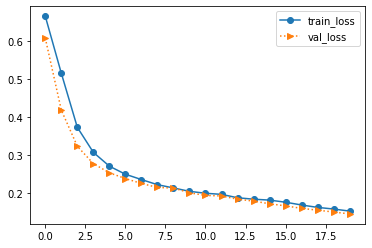

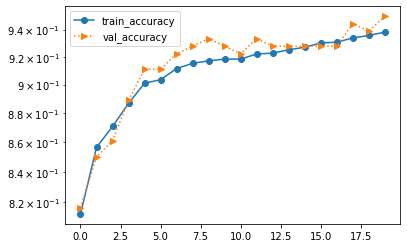

Final training accuracy is: 0.938
Final validation accuracy is: 0.950


In [16]:
# Define the criterion
criterion = nn.BCELoss()

# Define the model
simple_fc_model_digits= SimpleFCClassification(network_parameters=config_train_classification_digits['net_params'], 
                                          **additional_network_params)
simple_fc_model_digits = simple_fc_model_digits.to('cpu')
print("Model is:")
print(simple_fc_model_digits)

# Instantiate the Trainer
trainer_no_LOT = Trainer_classification(model=simple_fc_model_digits,
                                    xdata=flat_images,
                                    ydata=tgt,
                                    criterion=criterion,
                                    config=config_train_classification_digits,
                                    seed=12,
                                    device='cpu',
                                    print_after_epoch=1000
                                    )

# Train the model
trainer_no_LOT.train()

### plotting loss curves
plot_losses_trained_model(trainer_no_LOT)

With LOT orthogonal-ised linear layer

In [32]:
# we will need it later 
config_train_classification_LOT_digits = copy.deepcopy(config_train_classification_digits)
config_train_classification_LOT_digits['net_params']['projection'] = 'orthonormalize'
config_train_classification_LOT_digits['net_params']['LOT'] = {'LOT_iter': 10}
config_train_classification_LOT_digits['training_options']['epochs']=500

  6%|▌         | 3/51 [00:00<00:01, 24.89it/s]

Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


100%|██████████| 51/51 [00:02<00:00, 24.30it/s]


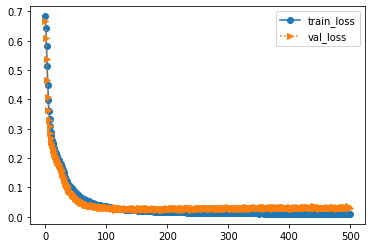

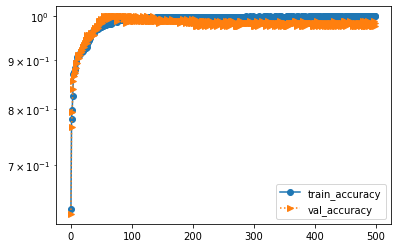

Final training accuracy is: 1.000
Final validation accuracy is: 0.983


In [33]:
## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_LOT_digits= SimpleFCClassification(network_parameters=config_train_classification_LOT_digits['net_params'],
                             **additional_network_params)
ds_simple_fc_LOT_digits =ds_simple_fc_LOT_digits.to('cpu')
print("model is:"); print(ds_simple_fc_LOT_digits)

### instantiate the Trainer 
trainer_classification_LOT_digits = Trainer_classification(model=ds_simple_fc_LOT_digits,
                                                xdata=flat_images_unnorm,
                                                ydata= tgt,
                                                criterion=criterion,
                                                config= config_train_classification_LOT_digits,
                                                seed=12,
                                                device='cpu',
                                                print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                                                )

### Let's train the model
trainer_classification_LOT_digits.train() ### 

### plotting loss curves
plot_losses_trained_model(trainer_classification_LOT_digits)

  8%|▊         | 4/51 [00:00<00:01, 33.11it/s]

Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


100%|██████████| 51/51 [00:01<00:00, 34.47it/s]


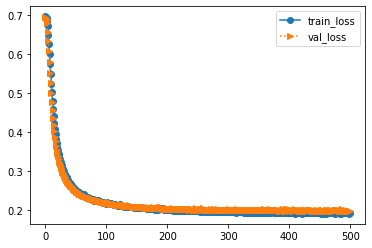

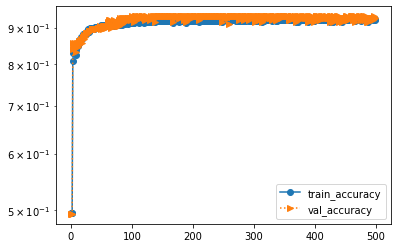

Final training accuracy is: 0.923
Final validation accuracy is: 0.928


In [34]:
## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_LOT_digits= SimpleFCClassification(network_parameters=config_train_classification_LOT_digits['net_params'],
                             **additional_network_params)
ds_simple_fc_LOT_digits =ds_simple_fc_LOT_digits.to('cpu')
print("model is:"); print(ds_simple_fc_LOT_digits)

### instantiate the Trainer 
trainer_classification_LOT_digits = Trainer_classification(model=ds_simple_fc_LOT_digits,
                                                xdata=flat_images,
                                                ydata= tgt,
                                                criterion=criterion,
                                                config= config_train_classification_LOT_digits,
                                                seed=12,
                                                device='cpu',
                                                print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                                                )

### Let's train the model
trainer_classification_LOT_digits.train() ### 

### plotting loss curves
plot_losses_trained_model(trainer_classification_LOT_digits)